In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14

projectDIR = "../../"

In [2]:
import sys
sys.path.append(projectDIR + "code")
# import Dataset
import dnatools

In [3]:
data = sio.loadmat(projectDIR + 'data/model_full_data.mat')
sd_scores = pd.DataFrame(index=dnatools.make_mer_list(6),data=data['Mer_scores'][:4**6*8].reshape(4**6,8)[:,2:6])
exonic_acceptor_scores = pd.read_pickle(projectDIR + 'data/exonic_acceptor_scores.series')
exonic_mer6_scores = pd.read_pickle(projectDIR + 'data/exonic_mer6_scores.series')
logit = lambda x: log(x)-log(1-x)
expit = lambda x: 1./(1.+exp(-x))

def score_seq(seq,mer_scores,mult_factor):
    score = 0.
    score += exonic_acceptor_scores.ix[seq[:3]]*mult_factor
    for b in range(len(seq)-5-6-3):
        score += mer_scores[seq[b:b+6]]*mult_factor
    # Score the SD:
    for b in range(4):
        score += sd_scores.ix[seq[len(seq)-9+b:len(seq)-9+6+b],b]*mult_factor
    return score

In [4]:
vexseq = pd.read_table(projectDIR + "data/vexseq/hal.txt", header=None) # contain all variants

In [5]:
vexseq.columns = ['ID', "REF_SEQ", "ALT_SEQ", "REF_PSI", "side", "isSNP"]

In [6]:
vexseq.head()

,ID,REF_SEQ,ALT_SEQ,REF_PSI,side,isSNP
0,chr1_114161116_C_A,TTTCACTCTTGTCGCCCAAGCTGGAGTGCAATGGCATGATCTCGGC...,TTTCACTCTTGTCGCCCAAGCTGGAGTGCAATGGCATGATCTCGGC...,48.884934,left,True
1,chr1_114161130_T_C,TTTCACTCTTGTCGCCCAAGCTGGAGTGCAATGGCATGATCTCGGC...,TTTCACTCTTGTCGCCCAAGCTGGAGTGCAATGGCATGATCTCGGC...,48.884934,left,True
2,chr1_114161136_AT_A,TTTCACTCTTGTCGCCCAAGCTGGAGTGCAATGGCATGATCTCGGC...,TTTCACTCTTGTCGCCCAAGCTGGAGTGCAATGGCATGATCTCGGC...,48.884934,left,False
3,chr1_114161147_C_T,TTTCACTCTTGTCGCCCAAGCTGGAGTGCAATGGCATGATCTCGGC...,TTTCACTCTTGTCGCCCAAGCTGGAGTGCAATGGCATGATCTCGGC...,48.884934,left,True
4,chr1_114161148_G_A,TTTCACTCTTGTCGCCCAAGCTGGAGTGCAATGGCATGATCTCGGC...,TTTCACTCTTGTCGCCCAAGCTGGAGTGCAATGGCATGATCTCGGC...,48.884934,left,True


In [7]:
# Add REF DPSI
refpsi = pd.read_csv(projectDIR+'data/vexseq/HepG2_delta_PSI_CAGI_training_sided.csv', index_col=0)

refpsi = refpsi[['ID', 'HepG2_delta_psi']]
refpsi = refpsi.rename(columns={'HepG2_delta_psi': 'DPSI'})

In [8]:
vexseq = vexseq.merge(refpsi, on='ID').reset_index(drop=True)

Filter out those out of HAL capability to train the scaling factor

In [9]:
vexseq = vexseq[vexseq['isSNP']]
vexseq = vexseq[vexseq.side.isnull()].reset_index(drop=True)

In [10]:
vexseq.shape

(486, 7)

In [11]:
def make_exon_skipping_predictions(df, mult_factor=None):
    if mult_factor is None:
        mult_factor = np.ones(len(df))*2.
    pred_psi = []
    SNP = []
    for i in range(len(df)):
        mut_seq = df.ALT_SEQ[i]
        ref_seq = df.REF_SEQ[i]
        if(dnatools.hamdist(mut_seq,ref_seq)==1):
            SNP.append(True)
        else:
            SNP.append(False)
        mut_score = score_seq(mut_seq,exonic_mer6_scores,mult_factor[i])
        ref_score = score_seq(ref_seq,exonic_mer6_scores,mult_factor[i])
        pred_psi.append(expit(logit(df.REF_PSI.iloc[i]/100.)+mut_score-ref_score))
    df['PSI_PRED'] = pred_psi
    df['SNP'] = SNP
#     df['DPSI'] = (df.ALT_PSI-df.REF_PSI)/100.
    df['DPSI_PRED'] = df.PSI_PRED-df.REF_PSI/100.
    return df

In [12]:
def optimize_scaling_factor(df):
    scaling_factors = {}
    for i in arange(1,4,0.1):
        df = make_exon_skipping_predictions(df, mult_factor=np.ones(len(df))*i)
        scaling_factors[i] = sum((df.DPSI_PRED-df.DPSI)**2)
    scaling_factors = pd.Series(scaling_factors)
    return scaling_factors.argmin()

In [13]:
import random
cross_val_inds = np.arange(len(vexseq))
random.seed(123)
random.shuffle(cross_val_inds)
cross_val_inds = np.array(cross_val_inds)

In [14]:
cross_validated_scaling_factors = np.ones(len(vexseq))
cross_val_group_size = len(vexseq)//10
for i in range(10):
    test_inds = cross_val_inds[cross_val_group_size*i:cross_val_group_size*(i+1)]
    training_inds = np.array(list(set(range(len(vexseq)))-set(test_inds)))
    training_set = vexseq.iloc[training_inds].reset_index(drop=True)
    cross_validated_scaling_factors[test_inds] = optimize_scaling_factor(training_set)
    print(i)

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


0
1
2
3
4
5
6
7
8
9


In [15]:
df = make_exon_skipping_predictions(vexseq, mult_factor=cross_validated_scaling_factors)

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


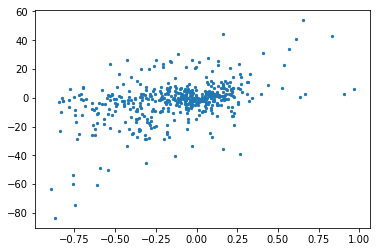

In [16]:
plt.scatter(df.DPSI_PRED, df.DPSI, s=5)
plt.show()

##  Optimize scaling factor with all training data, use it for test data

In [17]:
s = optimize_scaling_factor(vexseq)
s

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


3.9000000000000026

In [18]:
vextest = pd.read_csv(projectDIR+"data/vexseq/hal_test.txt", sep='\t', header=None)

In [19]:
vextest.columns = ['ID', "REF_SEQ", "ALT_SEQ", "REF_PSI"]

In [20]:
vextest.head()

,ID,REF_SEQ,ALT_SEQ,REF_PSI
0,chr10_114724268_T_C,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,89.024627
1,chr10_114724279_A_G,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,89.024627
2,chr10_114724280_T_G,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,89.024627
3,chr10_114724285_A_C,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,89.024627
4,chr10_114724289_C_A,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,89.024627


In [21]:
dftest = make_exon_skipping_predictions(vextest, mult_factor=np.repeat(s, len(vextest)))

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Merge in true DPSI for test

In [22]:
dpsitest = pd.read_csv(projectDIR + 'data/vexseq/Vexseq_HepG2_delta_PSI_CAGI_test_true.tsv', sep='\t')

In [23]:
dpsitest = dpsitest[['ID', 'HepG2_delta_psi']]

In [24]:
dpsitest = dpsitest.rename(columns={'HepG2_delta_psi': 'DPSI'})

In [25]:
dftest = dftest.merge(dpsitest, on='ID')

In [26]:
dftest.head()

,ID,REF_SEQ,ALT_SEQ,REF_PSI,PSI_PRED,SNP,DPSI_PRED,DPSI
0,chr10_114724268_T_C,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,89.024627,0.890246,False,1.110223e-16,-3.362128
1,chr10_114724279_A_G,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,89.024627,0.890246,False,1.110223e-16,-2.645510
2,chr10_114724280_T_G,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,89.024627,0.890246,False,1.110223e-16,-4.144964
3,chr10_114724285_A_C,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,89.024627,0.890246,False,1.110223e-16,-4.767620
4,chr10_114724289_C_A,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,CTCCATTTTCAGTCCGGCAGCACACATTACTCTGCGTACAAAACGA...,89.024627,0.890246,False,1.110223e-16,-2.762261


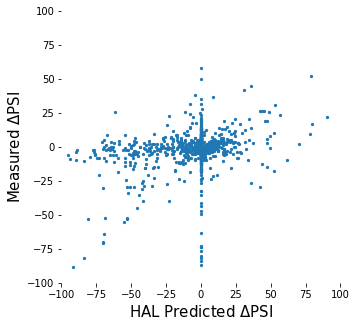

In [27]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.axis([-100,100,-100,100])
ax.scatter(dftest.DPSI_PRED*100, dftest.DPSI, s=5)
ax.set_xlabel("HAL Predicted $\Delta PSI$", fontsize=15)
ax.set_ylabel("Measured $\Delta PSI$", fontsize=15)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [28]:
dftest.to_csv(projectDIR + 'data/vexseq/HAL_test_pred.tsv')